**Table of contents**<a id='toc0_'></a>    
- [Example workflow in dockerHDDM](#toc1_)    
  - [Loading modules/packages](#toc1_1_)    
  - [Load the dataset](#toc1_2_)    
  - [Model specification and fitting](#toc1_3_)    
  - [Model diagnosis](#toc1_4_)    
    - [Diagnosis of Model 0](#toc1_4_1_)    
      - [Trace plot](#toc1_4_1_1_)    
      - [$\hat{R}$ and ESS](#toc1_4_1_2_)    
    - [Diagnosis of Model 5](#toc1_4_2_)    
      - [Trace plot](#toc1_4_2_1_)    
      - [$\hat{R}$ and ESS](#toc1_4_2_2_)    
    - [Diagnosis of Model 6](#toc1_4_3_)    
      - [Trace plot](#toc1_4_3_1_)    
      - [$\hat{R}$ and ESS](#toc1_4_3_2_)    
      - [non-converge example](#toc1_4_3_3_)    
  - [Model comparison and selection](#toc1_5_)    
    - [DIC](#toc1_5_1_)    
    - [PSIS-LOO-CV](#toc1_5_2_)    
      - [ WAIC](#toc1_5_2_1_)    
      - [PSIS-LOO-CV](#toc1_5_2_2_)    
    - [PSIS issues](#toc1_5_3_)    
  - [Posterior predictive check](#toc1_6_)    
    - [Custom PPC plotting function](#toc1_6_1_)    
  - [Statistical Inference](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Loading modules/packages](#toc0_)

In [1]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


## <a id='toc1_2_'></a>[Load the dataset](#toc0_)

In [2]:
data_F = hddm.load_csv('./HDDM_InconStim_6Frame.csv')

In [3]:
data_F.head(10)

subj_idx  trial        rt  stim_frame key_response  response blockname   
0    114192      2  0.984893           6            e         1  BlockFvN  \
1    114192      6  0.926056           6            e         1  BlockFvN   
2    114192      9  0.854008           6            e         1  BlockFvN   
3    114192     11  0.881858           6            e         1  BlockFvN   
4    114192     12  0.918875           6            e         1  BlockFvN   
5    114192     13  0.906791           6            e         1  BlockFvN   
6    114192     15  0.949124           6            f         0  BlockFvN   
7    114192     16  0.839553           6            e         1  BlockFvN   
8    114192     17  1.006603           6            f         0  BlockFvN   
9    114192     24  0.855258           6            f         0  BlockFvN   

   task stim_file  HSF_emo  LSF_emo  congruence  
0     1         A        2        1           2  
1     1         B        1        2           2  
2     1         B        1        2           2  
3     1         B        1        2           2  
4     1         B        1        2           2  
5     1         B        1        2           2  
6     1         A        2        1           2  
7     1         A        2        1           2  
8     1         A        2        1           2  
9     1         A        2        1           2

In [4]:
data_F.tail(10)

subj_idx  trial        rt  stim_frame key_response  response blockname   
9740    993849    330  0.601870           6            n         0  BlockF_1  \
9741    993849    331  0.681040           6            b         1  BlockF_1   
9742    993849    332  0.599069           6            b         1  BlockF_1   
9743    993849    334  0.551520           6            n         0  BlockF_1   
9744    993849    336  0.538108           6            b         1  BlockF_1   
9745    993849    339  0.776732           6            b         1  BlockF_1   
9746    993849    341  0.503375           6            n         0  BlockF_1   
9747    993849    343  0.515187           6            n         0  BlockF_1   
9748    993849    344  0.614084           6            b         1  BlockF_1   
9749    993849    349  0.615294           6            b         1  BlockF_1   

      task stim_file  HSF_emo  LSF_emo  congruence  
9740     2         B        1        2           2  
9741     2         A        2        1           2  
9742     2         B        1        2           2  
9743     2         A        2        1           2  
9744     2         B        1        2           2  
9745     2         A        2        1           2  
9746     2         A        2        1           2  
9747     2         B        1        2           2  
9748     2         A        2        1           2  
9749     2         B        1        2           2

In [5]:
print("The number of trials: ", data_F.shape[0])
print("The number of variables: ", data_F.shape[1])
print("The number of participants: ", data_F.subj_idx.unique().shape[0])

The number of trials:  9750
The number of variables:  12
The number of participants:  65


## <a id='toc1_3_'></a>[Model specification and fitting](#toc0_)

We select the baseline model and two models with lowest DIC for demo purpose.

In [6]:
# Make a copy of the dataset for use in the models
df = data_F.copy()

# Model 0: Base model where all parameters are estimated at the subject level
# In this model, 'z', 'v', 'a', and 't' are included, and no dependencies are defined
m0 = hddm.HDDM(df, include=['z', 'v', 'a', 't'])

# Model 1: Model with 'HSF_emo' as a predictor for 'v'
# In this model, we include 'z', 'v', 'a', and 't' and specify that 'v' is dependent on 'HSF_emo'
m5 = hddm.HDDM(df, include=['z', 'v', 'a', 't'], depends_on={'v': ['HSF_emo', 'task'], 'a': ['task']})

# Model 3: Model with multiple dependencies
# In this model, we include 'z', 'v', 'a', and 't' and specify that:
# 'v' is dependent on 'HSF_emo', and 'z' is dependent on 'task'
m6 = hddm.HDDM(df, include=['z', 'v', 'a', 't'], depends_on={'v': ['HSF_emo', 'task'], 'z': ['task']})          

No model attribute --> setting up standard HDDM
Set model to ddm
No model attribute --> setting up standard HDDM
Set model to ddm
No model attribute --> setting up standard HDDM
Set model to ddm


Fitting model with new features (parallel sampling and return inferenceData, see [dockerHDDM Quick View](./dockerHDDM_Quick_View.ipynb) and **Section New features in dockerHDDM**). 

We set up 4 MCMC chains with 5,000 samples with 2,500 burn-ins with parallel fitting process and return inferred data for by the code `model.sample(5000, burn = 2500, return_infdata = True)`.

In [7]:
def run_sampling(
    m,
    n_samples=5000,
    n_burn=2500,
    n_chains=4,
    model_name="m",
    progress_bar=False,
):
    """
    Run Markov Chain Monte Carlo (MCMC) sampling for a given model and parameters.
    This function takes a model parameter `m` and runs MCMC sampling using PyMC2.3.8.
    It returns a arviz InferenceData object containing the posterior samples and post-fit model.
    Parameters
    ----------
    m : object
        The model parameter to be sampled.
    n_samples : int, optional
        The number of posterior samples to generate. Default is 10000.
    n_burn : int, optional
        The number of initial samples to discard. Default is 5000.
    n_chains : int, optional
        The number of MCMC chains to run in parallel. Default is 4.
    model_name : str, optional
        The name of the model to be used in the sampling process. Default is "m".
    progress_bar : boolean, optional
        Default=True. Set False hide sampling progress bar. 
    Returns
    -------
    InferenceData : arviz.InferenceData
        A trace object containing the posterior samples.
    Model: HDDM
        A post-fit HDDM model. 
    """

    m_infdata = m.sample(n_samples,
                         burn=n_burn,
                         chains=n_chains,
                         return_infdata=True,
                         save_name="model_fitted/" + model_name,
                         progress_bar=progress_bar)

    return m, m_infdata

**Note: Fitting six model with settings (10000 samples) takes about 8-9 hours on a PC with Intel® Core™ i7-10700 CPU @ 2.90GHz. Also, the memory of should be large enough, ~ 64 G memory is recommended. Otherwise,  recommend few samples (e.g., n_samples=2500, burn=1000).**

In [8]:
%time
m0, m0_infdata = run_sampling(m0, model_name="m0")

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.15 µs


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


hddm sampling elpased time:  404.549 s
Start converting to InferenceData...


In [9]:
%time
# Set progress_bar=False to hide the program's progress bar to simplify the output
m5, m5_infdata = run_sampling(m5, model_name="m5")

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.62 µs


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


hddm sampling elpased time:  2030.064 s
Start converting to InferenceData...


In [10]:
%time
# Set progress_bar=False to hide the program's progress bar to simplify the output
m6, m6_infdata = run_sampling(m6, model_name="m6")

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.38 µs


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


hddm sampling elpased time:  2031.006 s
Start converting to InferenceData...


## <a id='toc1_4_'></a>[Model diagnosis](#toc0_)

We use `az.plot_trace()` to visually check the trace plot of MCMC chains and use `az.summary()` to check $\hat{R}$ and Effective Sample Size (ESS). 

### <a id='toc1_4_2_'></a>[Diagnosis of Model 0](#toc0_)

#### <a id='toc1_4_1_1_'></a>[Trace plot](#toc0_)

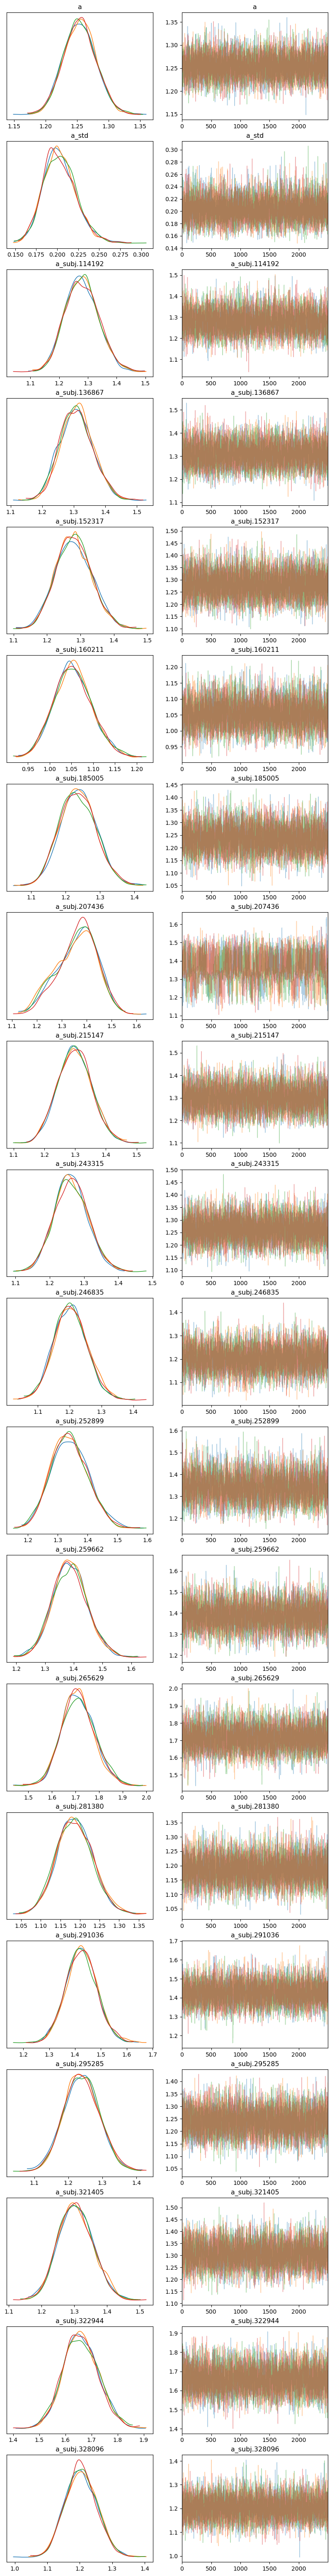

In [22]:
tmp_infdata = m0_infdata
plt.rc('font', size=16)

# plot traces for all parameters
axes = az.plot_trace(tmp_infdata, compact = False, figsize = [10, 80])

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


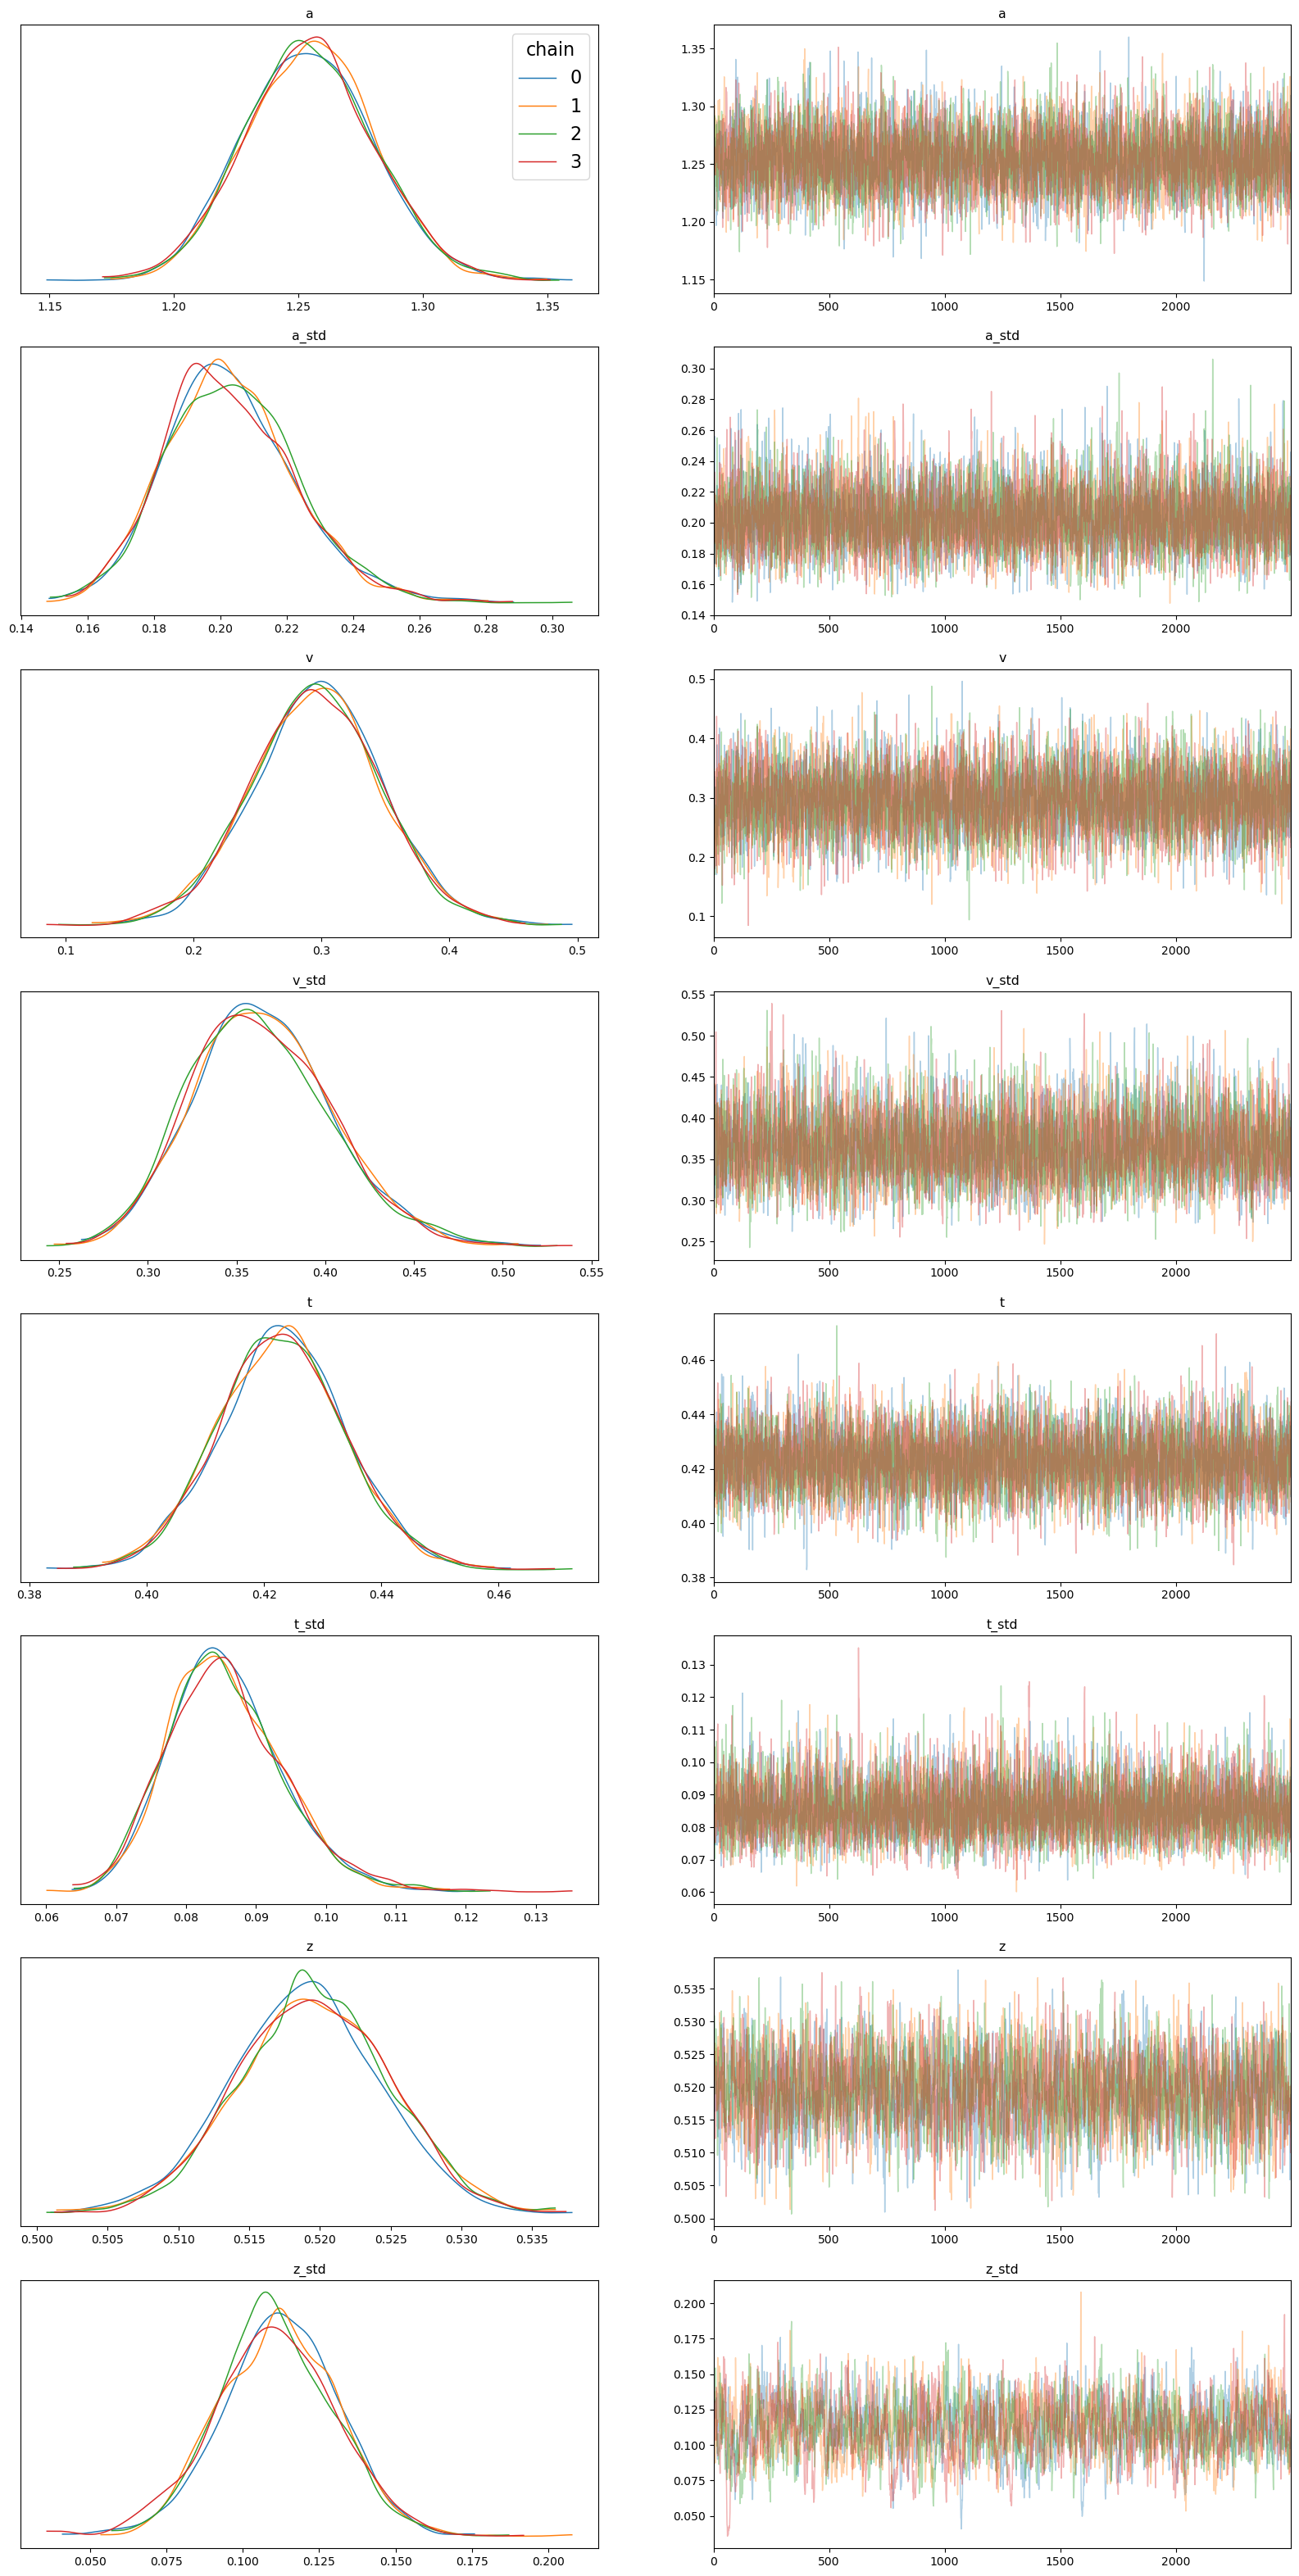

In [28]:
# select all population level parameters
axes = az.plot_trace(
    tmp_infdata, 
    var_names=['~subj'],  # exclude individual level parameters
    filter_vars='regex',
    compact = False, 
    legend=True, 
    figsize = [20, 40]
)

#### <a id='toc1_4_1_2_'></a>[$\hat{R}$ and ESS](#toc0_)

In [29]:
summary_tmp = az.summary(tmp_infdata, kind = "diagnostics", round_to=4)
summary_tmp.sort_values('r_hat', ascending=False).head(10)

mcse_mean  mcse_sd   ess_bulk   ess_tail   r_hat
t_subj.207436     0.0019   0.0014   547.2810  2001.4832  1.0037
z_std             0.0006   0.0004   981.9335  1155.1325  1.0036
a_subj.207436     0.0034   0.0024   609.1472  1722.7284  1.0035
z                 0.0001   0.0001  2085.4401  4344.1171  1.0029
a_subj.640358     0.0007   0.0005  4491.1367  6041.8741  1.0020
t_subj.640358     0.0002   0.0002  3308.7667  3925.9393  1.0019
t_subj.915780     0.0004   0.0003  3025.8145  2707.1548  1.0018
a_subj.259662     0.0009   0.0007  4311.2549  5560.2302  1.0017
a_subj.575285     0.0009   0.0006  3402.3131  5403.0257  1.0016
a_subj.915780     0.0012   0.0008  3139.4580  3042.3075  1.0016

### <a id='toc1_4_2_'></a>[Diagnosis of Model 5](#toc0_)

#### <a id='toc1_4_2_1_'></a>[Trace plot](#toc0_)

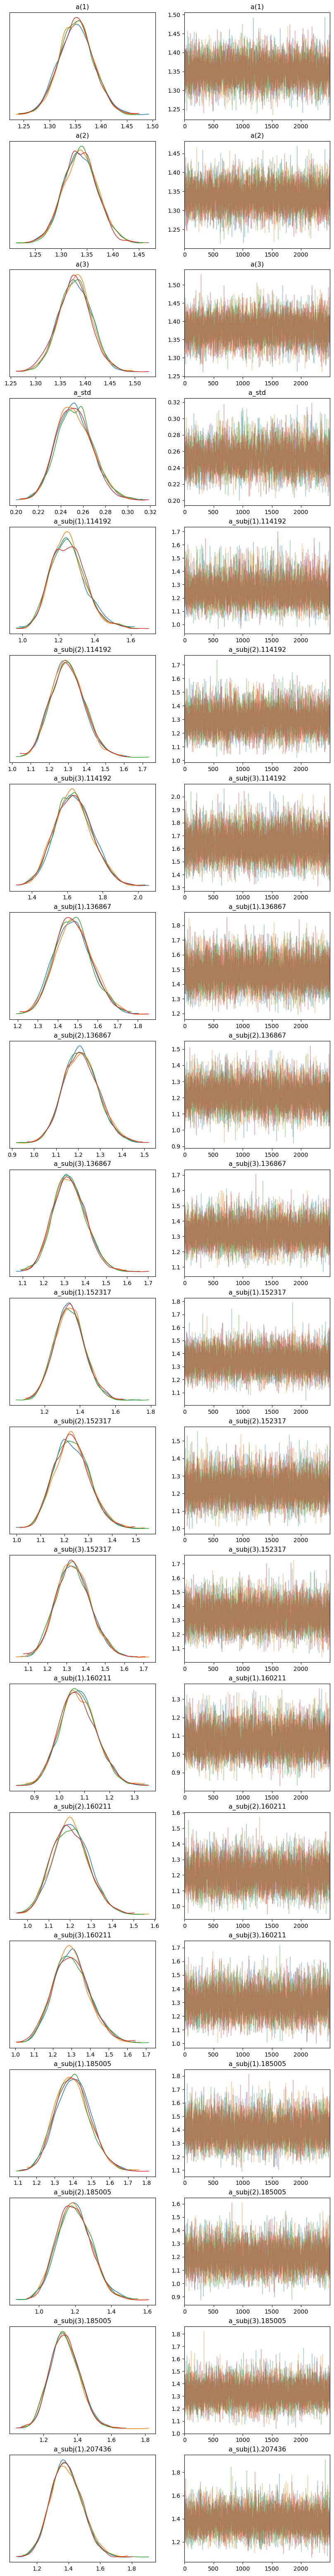

In [32]:
tmp_infdata = m5_infdata
plt.rc('font', size=16)

# plot traces for all parameters
axes = az.plot_trace(tmp_infdata, compact = False, figsize = [10, 80])

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


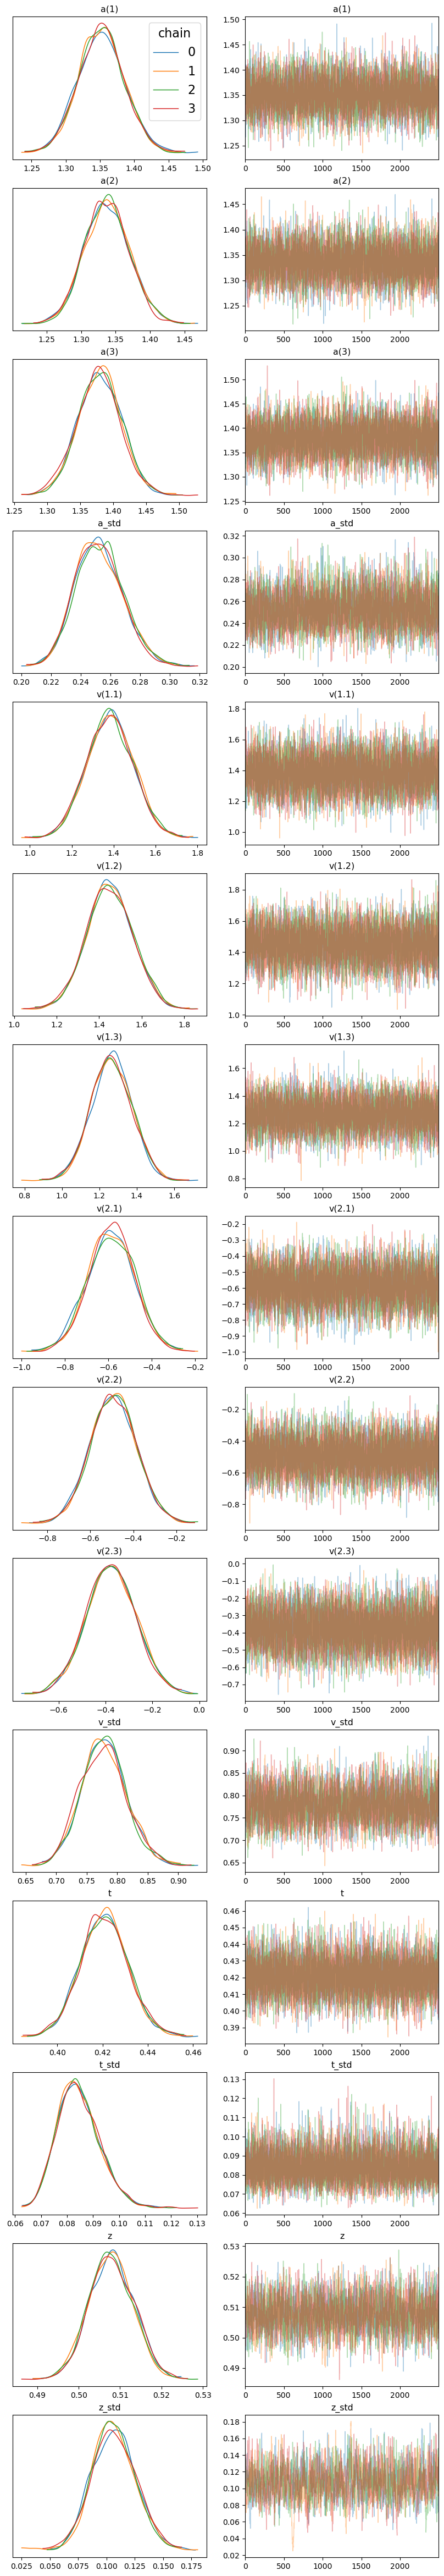

In [36]:
# select all population level parameters
axes = az.plot_trace(
    tmp_infdata, 
    var_names=['~subj'],  # exclude individual level parameters
    filter_vars='regex',
    compact = False, 
    legend=True, 
    figsize = [10, 60]
)

#### <a id='toc1_4_1_2_'></a>[$\hat{R}$ and ESS](#toc0_)

In [37]:
summary_tmp = az.summary(tmp_infdata, kind = "diagnostics", round_to=4)
summary_tmp.sort_values('r_hat', ascending=False).head(10)

mcse_mean  mcse_sd   ess_bulk   ess_tail   r_hat
t_subj.900295          0.0023   0.0017   472.8204   169.3576  1.0067
t_subj.989829          0.0008   0.0006  1027.8329  2410.6168  1.0060
a_subj(1).900295       0.0069   0.0052   641.5044   329.3256  1.0038
a_subj(2).900295       0.0043   0.0031   932.7391   709.0976  1.0036
t_subj.950977          0.0003   0.0002  2121.4770  4165.7643  1.0033
a_subj(1).989829       0.0035   0.0025  1427.4979  3396.7051  1.0029
t_subj.207436          0.0007   0.0006  1524.8633   655.2945  1.0027
z_subj.246835          0.0005   0.0004  2000.7769  3643.6986  1.0027
v_subj(2.1).473643     0.0043   0.0031  8952.4863  7290.1507  1.0024
t_subj.473643          0.0001   0.0001  4580.0167  3813.2195  1.0021

### <a id='toc1_4_2_'></a>[Diagnosis of Model 6](#toc0_)

#### <a id='toc1_4_2_1_'></a>[Trace plot](#toc0_)

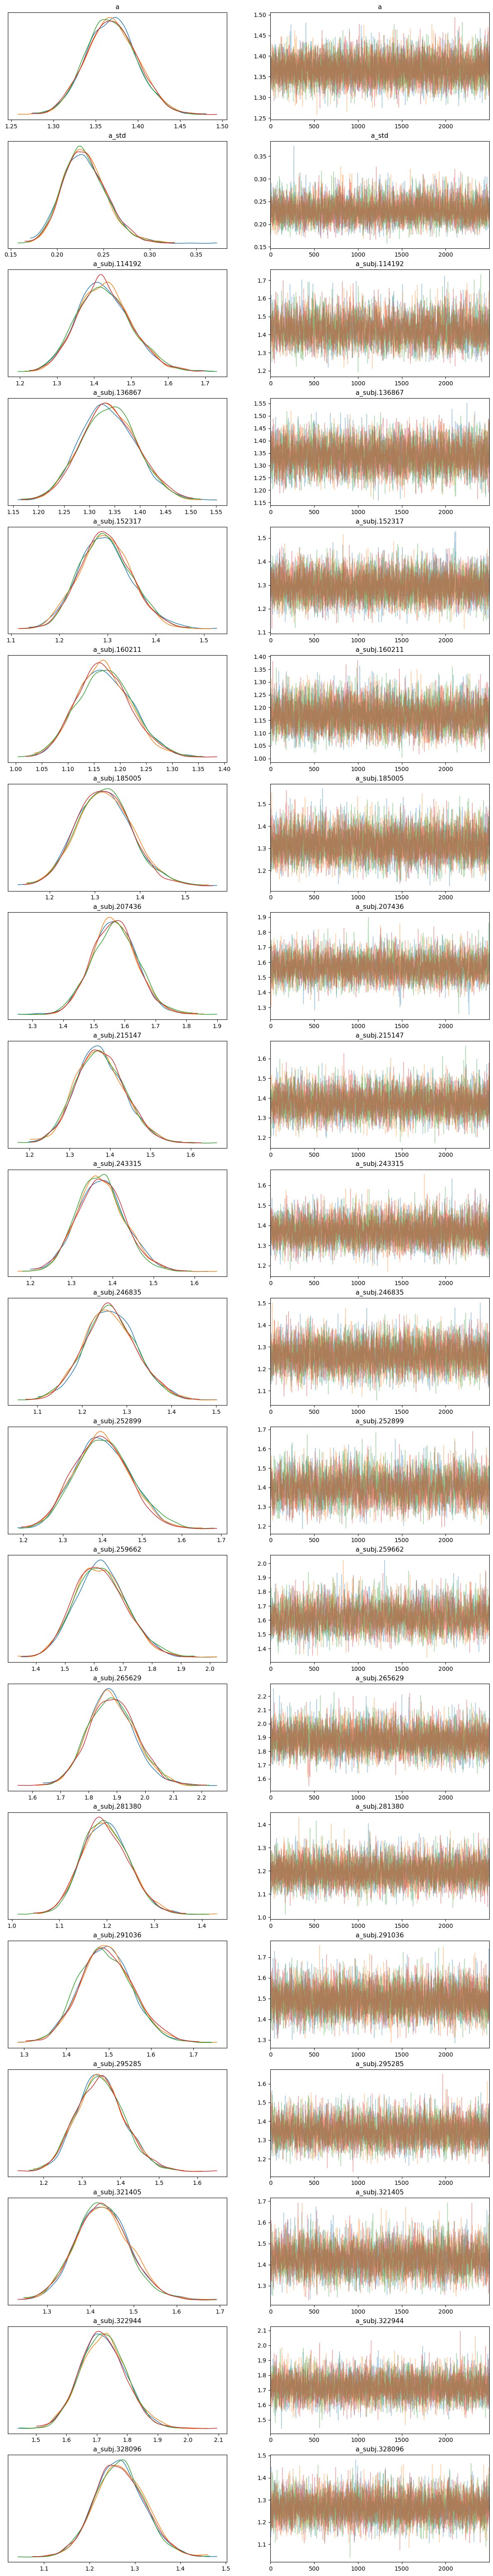

In [41]:
tmp_infdata = m6_infdata
plt.rc('font', size=16)

# plot traces for all parameters
axes = az.plot_trace(tmp_infdata, compact = False, figsize = [15, 80])

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


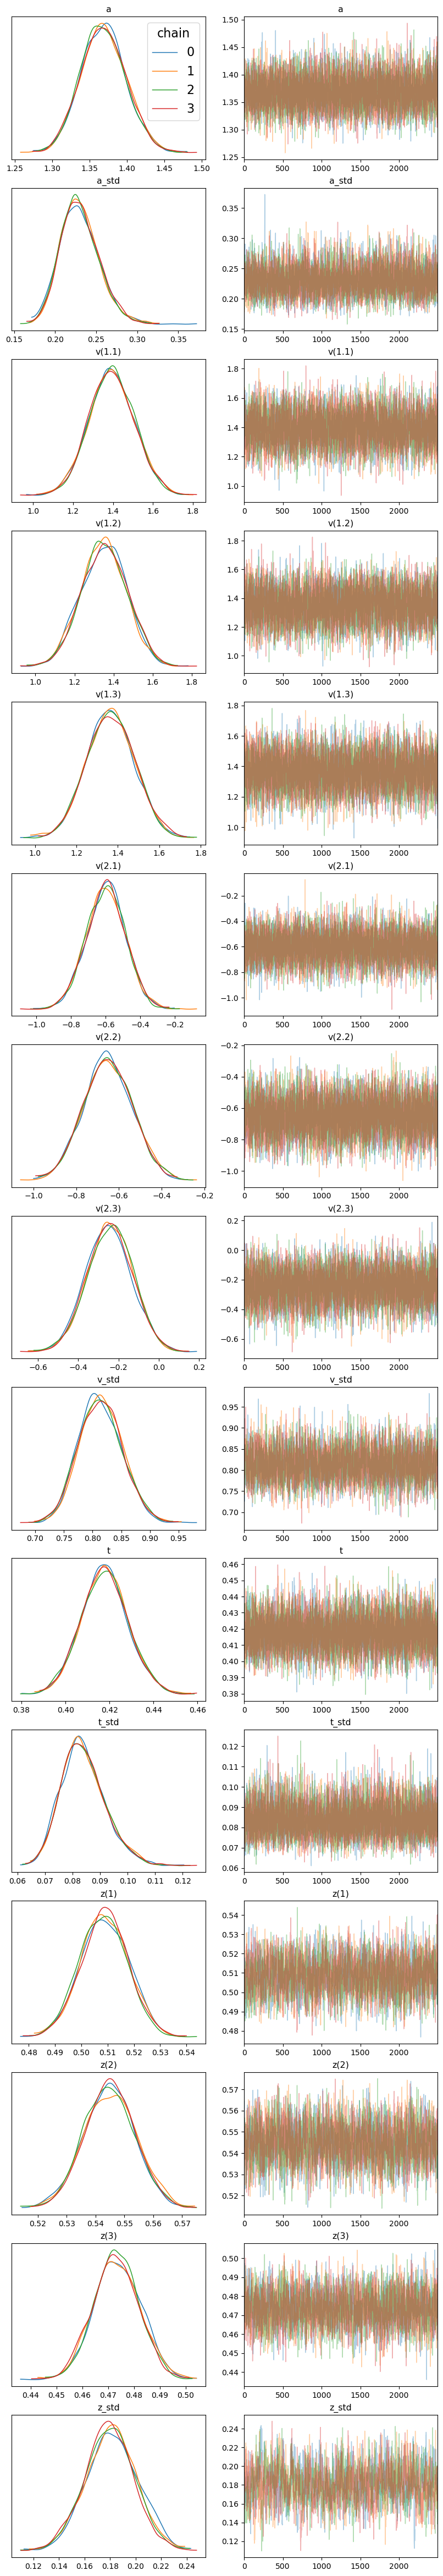

In [43]:
# select all population level parameters
axes = az.plot_trace(
    tmp_infdata, 
    var_names=['~subj'],  # exclude individual level parameters
    filter_vars='regex',
    compact = False, 
    legend=True, 
    figsize = [10, 60]
)

#### <a id='toc1_4_1_2_'></a>[$\hat{R}$ and ESS](#toc0_)

In [44]:
summary_tmp = az.summary(tmp_infdata, kind = "diagnostics", round_to=4)
summary_tmp.sort_values('r_hat', ascending=False).head(10)

mcse_mean  mcse_sd   ess_bulk   ess_tail   r_hat
t_subj.900295        0.0053   0.0038   143.6662   376.4838  1.0210
a_subj.900295        0.0093   0.0067   164.3258   368.9228  1.0154
z_subj(3).900295     0.0032   0.0022   207.0370   404.4645  1.0141
t_subj.989829        0.0007   0.0005   988.6542   919.4937  1.0077
z_subj(1).900295     0.0022   0.0016   334.3069  1097.2092  1.0069
z_subj(3).989829     0.0010   0.0007  1642.6953  1949.8114  1.0043
a_subj.989829        0.0022   0.0015  1235.0657  1146.8793  1.0035
z_std                0.0007   0.0005   799.9594  1492.5971  1.0034
t_subj.575285        0.0003   0.0002  3069.6275  4711.7642  1.0027
t_subj.950977        0.0004   0.0003  1514.7187  4394.1878  1.0027

## <a id='toc1_5_'></a>[Model comparison and selection](#toc0_)

### <a id='toc1_5_1_'></a>[DIC](#toc0_)

Here we retrieve the DIC from each model in the models and sort by DIC.

In [45]:
dic_dict = {
  "m0":m0.dic,
  "m5":m5.dic,
  "m6":m6.dic
}

comp_dic = pd.DataFrame.from_dict(dic_dict, orient='index', columns=['DIC'])
comp_dic['model'] = comp_dic.index
comp_dic = comp_dic[['model', 'DIC']]
comp_dic.sort_values(by=['DIC'], ascending = True)

model           DIC
m5    m5   9003.627699
m6    m6   9090.057342
m0    m0  12292.598839

## Get Population Coefficient Estimate

In [ ]:
# Get the population-level parameter estimates for models m5 and m6
params_m5 = m5.get_population_params()  # For model 5
params_m6 = m6.get_population_params()  # For model 6

# Extract the parameter names and their corresponding coefficient estimates
params_m5_df = pd.DataFrame(params_m5, columns=['Parameter', 'Estimate'])
params_m6_df = pd.DataFrame(params_m6, columns=['Parameter', 'Estimate'])

# Add a column to each dataframe indicating the model number
params_m5_df['Model'] = 5
params_m6_df['Model'] = 6

# Save the data to separate CSV files
params_m5_df.to_csv('m5_population_estimates.csv', index=False)
params_m6_df.to_csv('m6_population_estimates.csv', index=False)

print("CSV files 'm5_population_estimates.csv' and 'm6_population_estimates.csv' have been saved.")